In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
UAW_staff_by_year = [pd.read_csv(f"documents/UAW LM2s/{year}_staff.csv") for year in range(2005,2024)]
UAW_officers_by_year = [pd.read_csv(f"documents/UAW LM2s/{year}_officers.csv") for year in range(2005,2024)]
Teamsters_staff_by_year = [pd.read_csv(f"documents/Teamsters LM2s/{year}_staff.csv") for year in range(2005,2024)]
Teamsters_officers_by_year = [pd.read_csv(f"documents/Teamsters LM2s/{year}_officers.csv") for year in range(2005,2024)]

In [3]:
for i in range(19):
    UAW_staff_by_year[i]['Year'] = 2005 + i
    UAW_officers_by_year[i]['Year'] = 2005 + i
    Teamsters_staff_by_year[i]['Year'] = 2005 + i
    Teamsters_officers_by_year[i]['Year'] = 2005 + i

In [4]:
UAW_staff = pd.concat(UAW_staff_by_year).reset_index()
UAW_officers = pd.concat(UAW_officers_by_year).reset_index()
Teamsters_staff = pd.concat(Teamsters_staff_by_year).reset_index()
Teamsters_officers = pd.concat(Teamsters_officers_by_year).reset_index()

In [5]:
UAW_staff['Name'] = UAW_staff['First Name'] + ' ' + UAW_staff['Last Name']
UAW_officers['Name'] = UAW_officers['First Name'] + ' ' + UAW_officers['Last Name']
Teamsters_staff['Name'] = Teamsters_staff['First Name'] + ' ' + Teamsters_staff['Last Name']
Teamsters_officers['Name'] = Teamsters_officers['First Name'] + ' ' + Teamsters_officers['Last Name']

In [6]:
# Many of the titles annoying have spaces or incosistent capitalization.
# This cell removes all non-alpha characters and converts to uppercase.
f = lambda x: ("".join([a for a in str(x) if a.isalpha()])).upper()
UAW_staff['Title'] = UAW_staff['Title'].apply(f)
UAW_officers['Title'] = UAW_officers['Title'].apply(f)
Teamsters_staff['Title'] = Teamsters_staff['Title'].apply(f)
Teamsters_officers['Title'] = Teamsters_officers['Title'].apply(f)

In [7]:
def compute_retention(df):
    retention = pd.DataFrame({'Year':df['Year'].unique()}).set_index('Year')
    for i, year in enumerate(retention.index):
        current_staff = set(df[df['Year'] == year]['Name'])
        retention.loc[year, 'Total'] = len(current_staff)
        if i > 0:
            past_staff = set(df[df['Year'] == year - 1]['Name'])
            retention.loc[year, 'Retained'] = len(past_staff.intersection(current_staff))
            retention.loc[year, 'Turnover'] = -len(past_staff.difference(current_staff))
    retention['New'] = retention['Total'] - retention['Retained']
    return retention

UAW_staff_retention = compute_retention(UAW_staff)
UAW_officers_retention = compute_retention(UAW_officers)
Teamsters_staff_retention = compute_retention(Teamsters_staff)
Teamsters_officers_retention = compute_retention(Teamsters_officers)

# Charts

In [8]:
def plot_retentions(df, title):
    df = df.iloc[1:]
    fig, ax = plt.subplots(figsize = (8,3))
    plt.stackplot(df.index, 
                  df['Turnover'],
                  colors = 'r',
                  labels = ['Turnover'],
                 alpha = 0.5)
    plt.stackplot(df.index, 
                  df[['Retained', 'New']].transpose().values,
                  colors = ['tab:blue', 'g'],
                  labels = ['Retained', 'New'],
                 alpha = 0.5)

    plt.plot(df.index, df[['Turnover', 'Retained', 'Total']].values,
            color = 'black',
            marker = '.',
            linewidth = 1,
            )
    plt.plot(df.index, [0 for _ in df.index], color = 'black')

    ax.set_xticks(range(2005, 2024))
    ax.set_xticklabels(range(2005, 2024), rotation = 45)
    ax.set_ylabel("Number of staff")
    ax.set_xlabel("Year")

    handles, labels = plt.gca().get_legend_handles_labels()
    order = [2,1,0]
    plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
              loc = 'center left')
    plt.title(title, fontsize = 14)

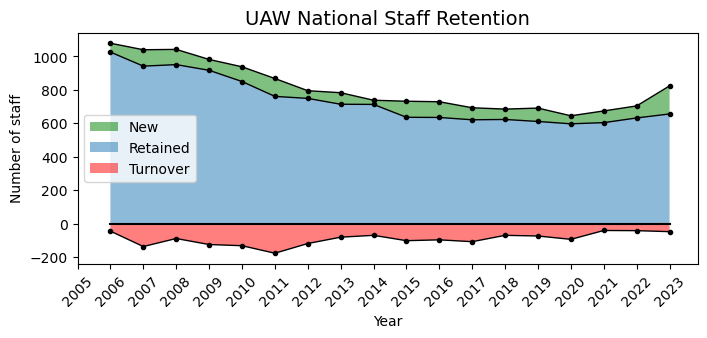

In [9]:
plot_retentions(UAW_staff_retention, "UAW National Staff Retention")

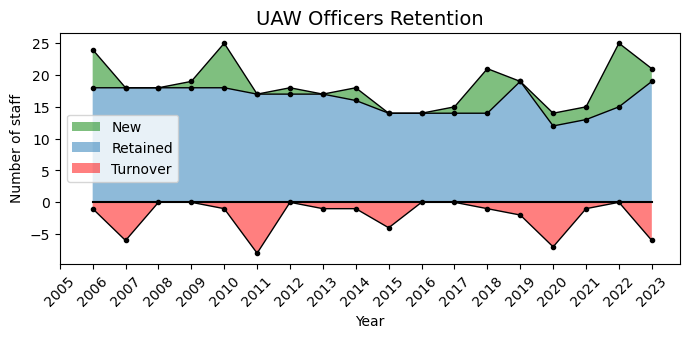

In [10]:
plot_retentions(UAW_officers_retention, "UAW Officers Retention")

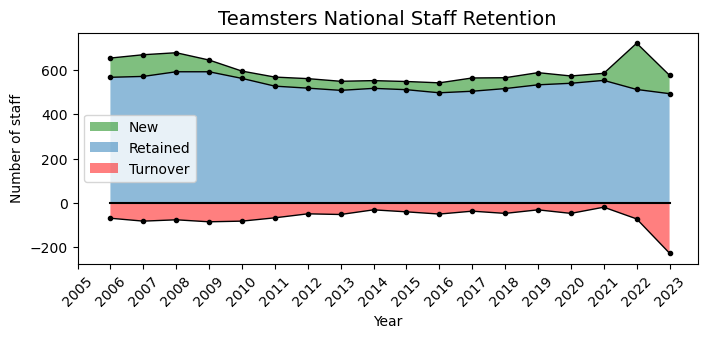

In [11]:
plot_retentions(Teamsters_staff_retention, "Teamsters National Staff Retention")

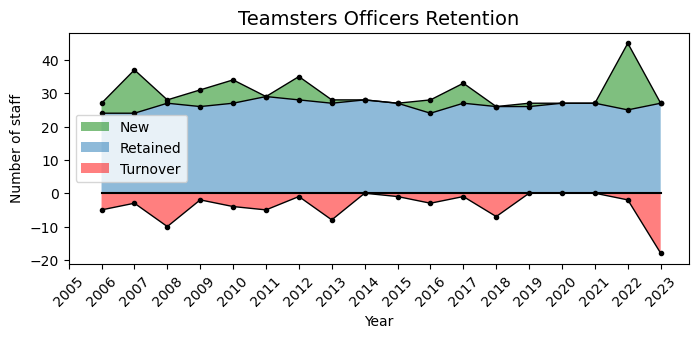

In [13]:
plot_retentions(Teamsters_officers_retention, "Teamsters Officers Retention")

# Analyzing individual staff and officer trajectories

In [14]:
def get_careers(df):
    df['Name'] = df['Name'].apply(lambda x: x.upper())
    names = df['Name'].unique()
    years = sorted(list(df['Year'].unique()))
    careers = {}
    for name in names:
        years_active = set(df[df['Name'] == name]['Year'])
        careers[name] = [1 if year in years_active else 0 for year in years]
    careers_df = pd.DataFrame.from_dict(careers, orient = 'columns')
    careers_df.index = years
    return careers_df

In [15]:
UAW_staff_careers = get_careers(UAW_staff)
UAW_officer_careers = get_careers(UAW_officers)
Teamsters_staff_careers = get_careers(Teamsters_staff)
Teamsters_officer_careers = get_careers(Teamsters_officers)

In [16]:
def plot_careers(careers_df):
    names = careers_df.columns
    first_year_active = [careers_df[name].ne(0).idxmax() for name in names]
    first_year, last_year = [careers_df.index.min(), careers_df.index.max()]
    low_end = 0.25
    high_end = 0.75
    colors = list([tuple(low_end + (high_end-low_end)*((year-first_year)/(last_year-first_year)) for _ in range(3)) for year in first_year_active])
    fig, ax = plt.subplots(figsize = (10,3))
    plt.stackplot(careers_df.index, 
                  careers_df.transpose().values,
                 colors = colors,
                  step='pre'
                 )
    ax.set_xticks(range(first_year, last_year+1))
    ax.set_xticklabels(range(first_year, last_year+1), rotation = 45)
    ax.set_xlabel("Year")
    ax.set_ylabel("Number employed")

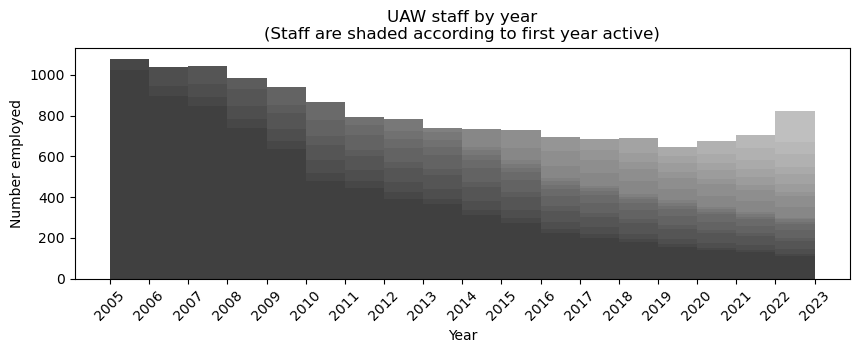

In [17]:
plot_careers(UAW_staff_careers)
plt.title("UAW staff by year\n(Staff are shaded according to first year active)")
plt.show()

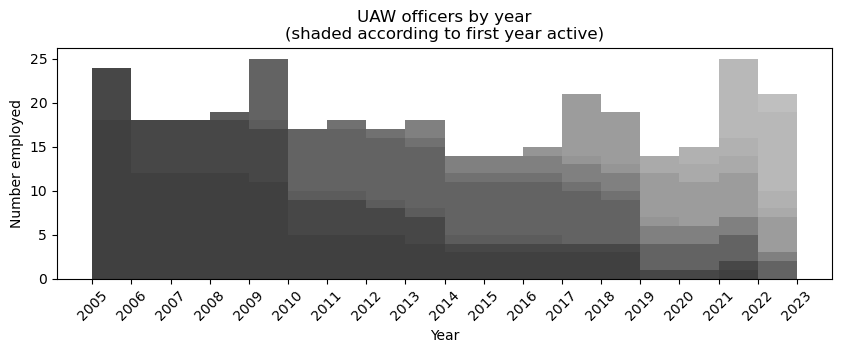

In [18]:
plot_careers(UAW_officer_careers)
plt.title("UAW officers by year\n(shaded according to first year active)")
plt.show()

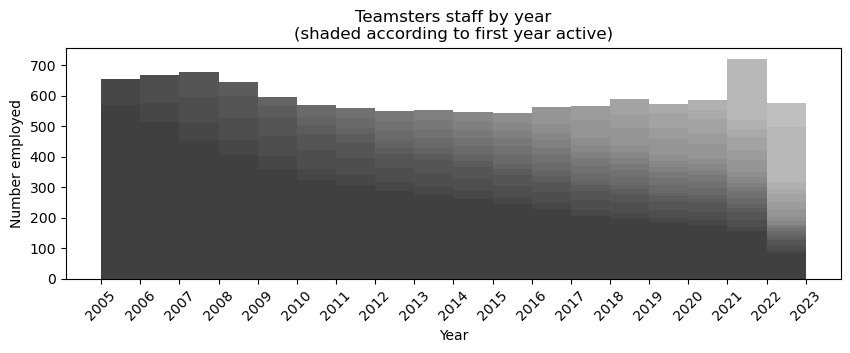

In [19]:
plot_careers(Teamsters_staff_careers)
plt.title("Teamsters staff by year\n(shaded according to first year active)")
plt.show()

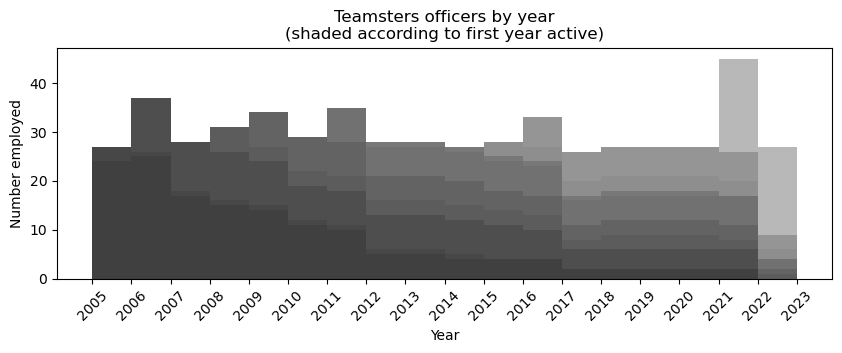

In [20]:
plot_careers(Teamsters_officer_careers)
plt.title("Teamsters officers by year\n(shaded according to first year active)")
plt.show()

# Analyze percents spent on various activities

In [52]:
activities = ['Representational Activities', 'Political Activities and Lobbying',
       'Contributions', 'General Overhead', 'Administration']

In [53]:
# Quality control: check that all staff have percents in each activity that
# add up to 100.
for df in [UAW_staff, UAW_officers, Teamsters_staff, Teamsters_officers]:
    assert list(df[activities].sum(axis = 1).unique()) == [100]

In [54]:
for activity in activities:
    UAW_staff[f"(Salary) {activity}"] = UAW_staff[activity]*UAW_staff['Salary']/100
    UAW_officers[f"(Salary) {activity}"] = UAW_officers[activity]*UAW_officers['Salary']/100
    Teamsters_staff[f"(Salary) {activity}"] = Teamsters_staff[activity]*Teamsters_staff['Salary']/100
    Teamsters_officers[f"(Salary) {activity}"] = Teamsters_officers[activity]*Teamsters_officers['Salary']/100

In [60]:
UAW_staff.groupby(by = 'Year')[[f"(Salary) {activity}" for activity in activities]].sum()

,(Salary) Representational Activities,(Salary) Political Activities and Lobbying,(Salary) Contributions,(Salary) General Overhead,(Salary) Administration
Year,,,,,
2005,82550615.34,5371896.89,86601.32,7221878.26,3166785.19
2006,82498803.74,5667625.08,33049.60,7242709.55,4949139.03
2007,81252873.29,5049360.99,549730.89,7372196.42,3004179.41
2008,82615106.66,6676498.36,593258.65,8056900.02,2649996.31
2009,78748892.69,6032194.94,577481.49,8265799.89,2525943.99
2010,64162223.26,5021823.39,9115.46,6643249.31,2602037.58
2011,66505543.87,5053962.37,0.00,6770498.07,2377636.69
2012,64246252.59,5435821.67,3084.97,5430290.23,2194230.54
2013,64981111.52,4385405.33,4122.79,5292821.94,2349012.42


In [82]:
def plot_budget_for_activities(df):
    years = sorted(df['Year'].unique())
    df = df.groupby(by = 'Year')[[f"(Salary) {activity}" for activity in activities]].sum()
    rep = df['(Salary) Representational Activities']
    political = df['(Salary) Political Activities and Lobbying']
    other = df[['(Salary) Contributions', '(Salary) General Overhead', '(Salary) Administration']].sum(axis = 1)
    fig,ax = plt.subplots(figsize = (10,3))
    plt.stackplot(years, 
                  [other, rep, political],
                 labels = ['Other', 'Representation / Organizing', 'Political Activities']
                 )
    ax.set_xticks(years)
    ax.set_xticklabels(years, rotation = 45)
    plt.legend()

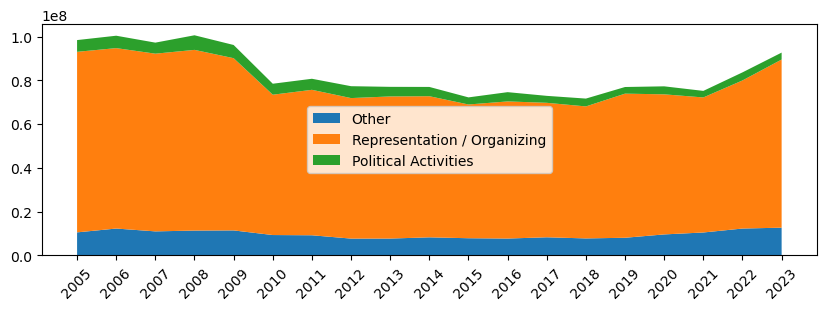

In [83]:
plot_budget_for_activities(UAW_staff)

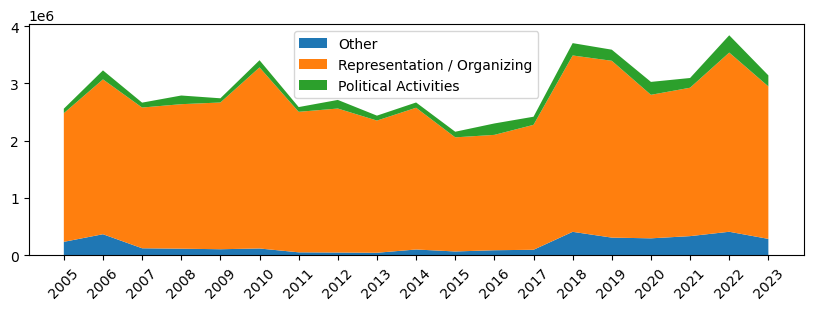

In [84]:
plot_budget_for_activities(UAW_officers)

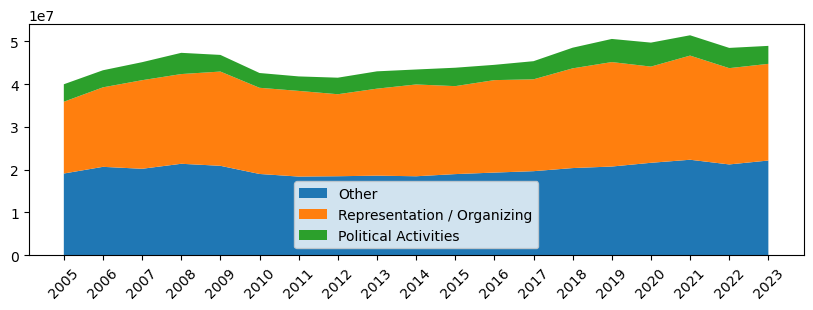

In [85]:
plot_budget_for_activities(Teamsters_staff)